### **Sessão e leitura dos dados**

In [3]:
# Instalando o PySpark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=e193a8b6d02e321f6c22167ad1d70ca573f4ad34800e1c97e1b90981b872034f
  Stored in directory: /root/.cache/pip/wheels/9f/34/a4/159aa12d0a510d5ff7c8f0220abbea42e5d81ecf588c4fd884
Successfully built pyspark


In [4]:
# Iniciando uma sessão
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("analise_nlp") \
    .getOrCreate()

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# baixando o kaggle: https://www.kaggle.com/datasets/luisfredgs/imdb-ptbr
# Leitura dos dados:
# 1. Pela conexão com o google drive #2. Pelo carregamento no colab.(<---)
dados = spark.read.parquet("/content/drive/MyDrive/GitHub/Pyspark/Dados/imdb-reviews-pt-br.parquet",
                       inferSchema= True,
                       header = True)

### **Explorando os dados**

Agora que já lemos os dados, vamos explorá-lo entendendo:

* O **tamanho** dos dados
* Os **campos** e o tipo
* O **conteúdo** em cada campo
* A **proporção** das categorias


In [8]:
# O tamanho dos dados
print(f'N° de Linhas:{dados.count()}', f'N° de colunas:{len(dados.columns)}')

N° de Linhas:49459 N° de colunas:4


In [9]:
# campos e tipos
dados.printSchema()

root
 |-- id: integer (nullable = true)
 |-- text_en: string (nullable = true)
 |-- text_pt: string (nullable = true)
 |-- sentiment: string (nullable = true)



In [10]:
# Conteudo
dados.limit(99).show()

+-----+--------------------+--------------------+---------+
|   id|             text_en|             text_pt|sentiment|
+-----+--------------------+--------------------+---------+
|25866|This bogus journe...|Esta jornada fals...|      neg|
|25867|First off...with ...|Em primeiro lugar...|      neg|
|25868|Hallam Foe tells ...|Hallam Foe nos co...|      neg|
|25869|In its way, Miste...|Em seu caminho, o...|      neg|
|25870|David Mackenzies ...|Seguimento David ...|      neg|
|25871|I saw this film f...|Eu vi esse filme ...|      neg|
|25872|Once again I have...|Mais uma vez eu v...|      neg|
|25873|I just finished r...|Acabei de ler um ...|      neg|
|25874|Proof why Hollywo...|Prova porque as c...|      neg|
|25875|Near the beginnin...|Perto do começo, ...|      neg|
|25876|First off, I must...|Em primeiro lugar...|      neg|
|25877|I recently watche...|Recentemente, ass...|      neg|
|25878|Its interesting t...|É interessante ve...|      neg|
|25879|"I Love New York"...|"I Love New 

In [11]:
# Apresentando alguns comentários ditos como negativo ou positivo.
print("Negativo")
dados.filter(dados.id == 190).select("text_pt").show(truncate = False)
print("Positivo")
dados.filter(dados.id == 12427).select("text_pt").show(truncate = False)

Negativo
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text_pt                                                                                                                 

In [12]:
# Contabilizando os tipos de comentários
dados.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



### **Limpando e processando os dados**
 
Para que o computador compreenda nossa linguagem é importante realizar algumas transformações no intuito de faciliar essa compreensão. Para isso, primeiramente podemos realizar a **limpeza dos dados**, que consiste na **remoção de caracteres que não contribui** na distinção dos sentimentos dos comentários dos nossos clientes, podemos citar por exemplos, remover caracteres especiais e espaços no início e fim dos comentários.


Logo após a limpeza de caracteres não relevantes, precisamos realizar o procedimento de **Tokenização**, que consiste no processo de **dividir uma frase** em palavras ou tokens (parte do texto) individuais.

E para finalizar o processamento dos nossos dados, iremos realizar a retirada de **stopwords**, ou seja, aquelas palavras que não auxiliam na classificação ou identificação do texto, em sua maioria são **preposições, artigos, pronomes .**..
 
 

In [13]:
#Lembrando como estão nossos dados
dados.limit(10).show()

+-----+--------------------+--------------------+---------+
|   id|             text_en|             text_pt|sentiment|
+-----+--------------------+--------------------+---------+
|25866|This bogus journe...|Esta jornada fals...|      neg|
|25867|First off...with ...|Em primeiro lugar...|      neg|
|25868|Hallam Foe tells ...|Hallam Foe nos co...|      neg|
|25869|In its way, Miste...|Em seu caminho, o...|      neg|
|25870|David Mackenzies ...|Seguimento David ...|      neg|
|25871|I saw this film f...|Eu vi esse filme ...|      neg|
|25872|Once again I have...|Mais uma vez eu v...|      neg|
|25873|I just finished r...|Acabei de ler um ...|      neg|
|25874|Proof why Hollywo...|Prova porque as c...|      neg|
|25875|Near the beginnin...|Perto do começo, ...|      neg|
+-----+--------------------+--------------------+---------+



### **WordCloud**

A nuvem de palavras é um recurso visual muito utilizado para entender as palavras mais frequentes de um texto. Aqui usaremos a própria biblioteca do Python `WordCloud`. 

A ideia é coletar as palavras usando *list comprehension* e aplicando a função `collect()` em uma [amostra](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.sample.html), já que esta função exige muitos recursos de processamento do spark.


In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

amostra = dados.select('text_pt').sample(fraction = 0.1, seed = 101)
tudo = [texto['text_pt'] for texto in amostra.collect()]

In [15]:
wordcloud = WordCloud(background_color = 'white',
                      width = 1000,
                      height = 600,
                      collocations = False, 
                      prefer_horizontal = 1).generate(str(tudo))

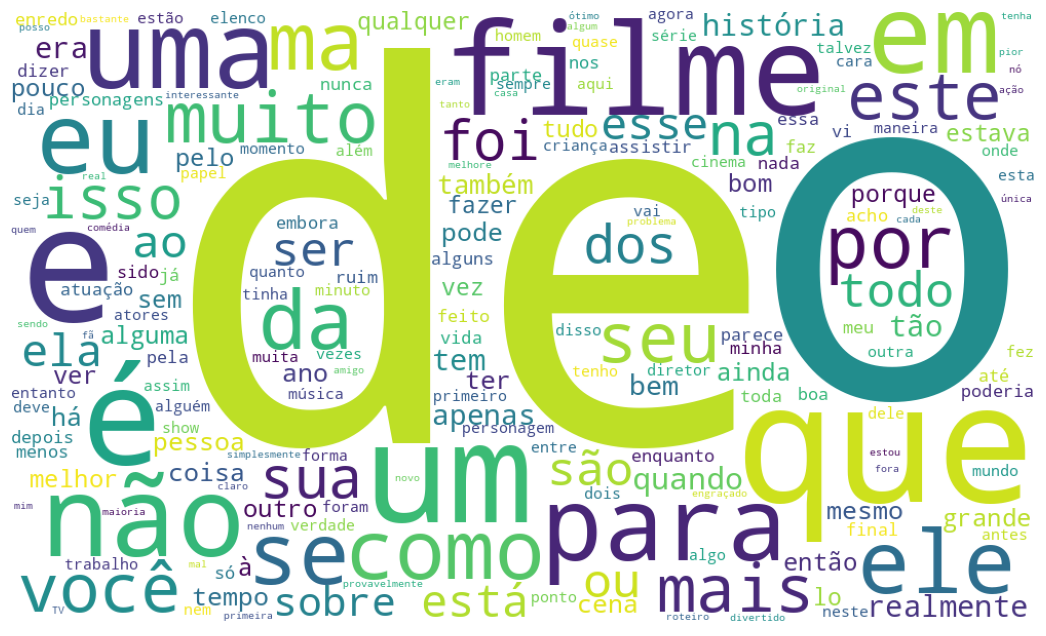

In [16]:
plt.figure(figsize=(20,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### **Limpeza**: caracteres especiais

In [17]:
# queremos remover esses tipos de caracteres
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [18]:
# exemplo de dataframe para a limpeza de caracteres especiais
amostra = spark.createDataFrame([
       ("Oi, JP! Blz?",),
       ("$$$\\ |~ Parabéns ~| \\$$$",),
       ("(#amovc #paz&amor ^.^)",),
       ("\"bora *_* \"",),
       ("=>->'...``` vc foi selecionad@ ´´´...'<=<-",),
       ("{comprar: arroz; feijão e pepino}  //",),
       ("!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~",),
       ("ana@gmail.com",)
], ["textos"])


In [19]:
#amostra.show(truncate=False)
import pyspark.sql.functions as f

amostra = amostra.withColumn("texto_regex", f.regexp_replace("textos", "[\$#,\"!%&'()*+-./:;<=>?@^_`´{|}~\\\\]", ""))



In [20]:
amostra.show(truncate = False)

+------------------------------------------+-------------------------------+
|textos                                    |texto_regex                    |
+------------------------------------------+-------------------------------+
|Oi, JP! Blz?                              |Oi JP Blz                      |
|$$$\ |~ Parabéns ~| \$$$                  |  Parabéns                     |
|(#amovc #paz&amor ^.^)                    |amovc pazamor                  |
|"bora *_* "                               |bora                           |
|=>->'...``` vc foi selecionad@ ´´´...'<=<-| vc foi selecionad             |
|{comprar: arroz; feijão e pepino}  //     |comprar arroz feijão e pepino  |
|!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~          |[]                             |
|ana@gmail.com                             |anagmailcom                    |
+------------------------------------------+-------------------------------+



In [21]:
# Tirando os espaços em brancos no exemplo.
amostra = amostra.withColumn("texto_limpo", f.trim(amostra.texto_regex))
amostra.show(truncate = False)

+------------------------------------------+-------------------------------+-----------------------------+
|textos                                    |texto_regex                    |texto_limpo                  |
+------------------------------------------+-------------------------------+-----------------------------+
|Oi, JP! Blz?                              |Oi JP Blz                      |Oi JP Blz                    |
|$$$\ |~ Parabéns ~| \$$$                  |  Parabéns                     |Parabéns                     |
|(#amovc #paz&amor ^.^)                    |amovc pazamor                  |amovc pazamor                |
|"bora *_* "                               |bora                           |bora                         |
|=>->'...``` vc foi selecionad@ ´´´...'<=<-| vc foi selecionad             |vc foi selecionad            |
|{comprar: arroz; feijão e pepino}  //     |comprar arroz feijão e pepino  |comprar arroz feijão e pepino|
|!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~    

In [22]:
#1. retirando os caracteres especiais dos dados
dados = dados.withColumn("texto_regex", f.regexp_replace("text_en", "[\$#,\"!%&'()*+-./:;<=>?@^_`´{|}~\\\\]", ""))


In [23]:
dados.limit(2).show(truncate=False)

+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [24]:
#2. tirar espaços do começo e do final de cada frase:
# poderiamos usar regex, mas vamos usar o trim
dados = dados.withColumn("texto_limpo", f.trim(dados.texto_regex) )

In [25]:
dados.limit(2).show()

+-----+--------------------+--------------------+---------+--------------------+--------------------+
|   id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|
+-----+--------------------+--------------------+---------+--------------------+--------------------+
|25866|This bogus journe...|Esta jornada fals...|      neg|This bogus journe...|This bogus journe...|
|25867|First off...with ...|Em primeiro lugar...|      neg|First offwith nam...|First offwith nam...|
+-----+--------------------+--------------------+---------+--------------------+--------------------+



#### **Tokenização**: divisão em tokens

In [26]:
#3. tokenizando os dados
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol = "texto_limpo", outputCol = "tokens")
tokenizado = tokenizer.transform(dados)

In [27]:
tokenizado.select("texto_limpo", "tokens").show()

+--------------------+--------------------+
|         texto_limpo|              tokens|
+--------------------+--------------------+
|This bogus journe...|[this, bogus, jou...|
|First offwith nam...|[first, offwith, ...|
|Hallam Foe tells ...|[hallam, foe, tel...|
|In its way Mister...|[in, its, way, mi...|
|David Mackenzies ...|[david, mackenzie...|
|I saw this film f...|[i, saw, this, fi...|
|Once again I have...|[once, again, i, ...|
|I just finished r...|[i, just, finishe...|
|Proof why Hollywo...|[proof, why, holl...|
|Near the beginnin...|[near, the, begin...|
|First off I must ...|[first, off, i, m...|
|I recently watche...|[i, recently, wat...|
|Its interesting t...|[its, interesting...|
|I Love New York i...|[i, love, new, yo...|
|The latest Rumor ...|[the, latest, rum...|
|i think that new ...|[i, think, that, ...|
|This is the most ...|[this, is, the, m...|
|It must be the mo...|[it, must, be, th...|
|I love the episod...|[i, love, the, ep...|
|I always wrote th...|[i, always

In [28]:
from pyspark.sql.types import IntegerType

# Entendendo em quantos tokens os comentários foram divididos.
countTokens = f.udf(lambda tokens: len(tokens), IntegerType())
tokenizado.select("texto_limpo", "tokens")\
          .withColumn("Freq_tokens", countTokens(f.col("tokens"))).show()

+--------------------+--------------------+-----------+
|         texto_limpo|              tokens|Freq_tokens|
+--------------------+--------------------+-----------+
|This bogus journe...|[this, bogus, jou...|        179|
|First offwith nam...|[first, offwith, ...|        351|
|Hallam Foe tells ...|[hallam, foe, tel...|        457|
|In its way Mister...|[in, its, way, mi...|        254|
|David Mackenzies ...|[david, mackenzie...|        660|
|I saw this film f...|[i, saw, this, fi...|        188|
|Once again I have...|[once, again, i, ...|        687|
|I just finished r...|[i, just, finishe...|        168|
|Proof why Hollywo...|[proof, why, holl...|        543|
|Near the beginnin...|[near, the, begin...|        272|
|First off I must ...|[first, off, i, m...|        202|
|I recently watche...|[i, recently, wat...|        196|
|Its interesting t...|[its, interesting...|        206|
|I Love New York i...|[i, love, new, yo...|        353|
|The latest Rumor ...|[the, latest, rum...|     

#### **StopWords**: remoção de ruídos

Podemos usar o [`StopWordsRemover()`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.StopWordsRemover.html) nativo do spark, ou o [`stopwords()`](https://openbase.com/js/nltk-stopwords/documentation) da biblioteca nltk do Python. Dentre muitas linguagens, ambas bibliotecas dão suporte para o português.

Vamos começar com um **exemplo pequeno** e depois aplicar em nossos dados.

In [29]:
# Exemplo pequeno
data = [(1, 'Spark é ótimo e NLP com Spark é fácil'), 
        (0, 'Spark MLlib não ajuda muito'), 
        (1, 'O MLlib do Spark ajuda e é fácil')]
        
colNames = ['label', 'texto_limpo']
df = spark.createDataFrame(data, colNames)

In [30]:
#Exemplo explorando bibliotecas. (nltk)
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
stop_A = stopwords.words("portuguese")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [31]:
#Exemplo explorando bibliotecas. (pyspark)
from pyspark.ml.feature import StopWordsRemover

stop_B = StopWordsRemover.loadDefaultStopWords("portuguese")

In [32]:
# exemplo comparando os diferentes stopwords #A
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol = "texto_limpo", outputCol = "tokens")
tokenized = tokenizer.transform(df)


In [33]:
remover = StopWordsRemover(inputCol = "tokens", outputCol = "texto_final", stopWords= stop_A)
df = remover.transform(tokenized)

In [34]:
df.show(truncate = False)

+-----+-------------------------------------+-----------------------------------------------+---------------------------------+
|label|texto_limpo                          |tokens                                         |texto_final                      |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------+
|1    |Spark é ótimo e NLP com Spark é fácil|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|[spark, ótimo, nlp, spark, fácil]|
|0    |Spark MLlib não ajuda muito          |[spark, mllib, não, ajuda, muito]              |[spark, mllib, ajuda]            |
|1    |O MLlib do Spark ajuda e é fácil     |[o, mllib, do, spark, ajuda, e, é, fácil]      |[mllib, spark, ajuda, fácil]     |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------+



In [35]:
# exemplo comparando os diferentes stopwords #B
remover = StopWordsRemover(inputCol = "tokens", outputCol = "texto_final", stopWords=stop_B)
df = remover.transform(tokenized)

In [36]:
df.show(truncate = False)

+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+
|label|texto_limpo                          |tokens                                         |texto_final                            |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+
|1    |Spark é ótimo e NLP com Spark é fácil|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|[spark, é, ótimo, nlp, spark, é, fácil]|
|0    |Spark MLlib não ajuda muito          |[spark, mllib, não, ajuda, muito]              |[spark, mllib, ajuda]                  |
|1    |O MLlib do Spark ajuda e é fácil     |[o, mllib, do, spark, ajuda, e, é, fácil]      |[mllib, spark, ajuda, é, fácil]        |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+



In [37]:
# 4. Retirando os stopwords dos depoimentos
remover = StopWordsRemover(inputCol = "tokens", outputCol = "texto_final")
feature_data = remover.transform(tokenizado)


In [38]:
feature_data.limit(11).show()

+-----+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
|   id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|              tokens|         texto_final|
+-----+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
|25866|This bogus journe...|Esta jornada fals...|      neg|This bogus journe...|This bogus journe...|[this, bogus, jou...|[bogus, journey, ...|
|25867|First off...with ...|Em primeiro lugar...|      neg|First offwith nam...|First offwith nam...|[first, offwith, ...|[first, offwith, ...|
|25868|Hallam Foe tells ...|Hallam Foe nos co...|      neg|Hallam Foe tells ...|Hallam Foe tells ...|[hallam, foe, tel...|[hallam, foe, tel...|
|25869|In its way, Miste...|Em seu caminho, o...|      neg|In its way Mister...|In its way Mister...|[in, its, way, mi...|[way, mister, 

In [39]:
# Contagem de tokens antes e depois do stopwords.
feature_data.select("tokens", "texto_final")\
          .withColumn("Freq_tokens", countTokens(f.col("tokens")))\
          .withColumn("Freq_tokens_limpos",  countTokens(f.col("texto_final"))).show()


+--------------------+--------------------+-----------+------------------+
|              tokens|         texto_final|Freq_tokens|Freq_tokens_limpos|
+--------------------+--------------------+-----------+------------------+
|[this, bogus, jou...|[bogus, journey, ...|        179|               104|
|[first, offwith, ...|[first, offwith, ...|        351|               221|
|[hallam, foe, tel...|[hallam, foe, tel...|        457|               230|
|[in, its, way, mi...|[way, mister, foe...|        254|               146|
|[david, mackenzie...|[david, mackenzie...|        660|               345|
|[i, saw, this, fi...|[saw, film, first...|        188|                96|
|[once, again, i, ...|[seen, movie, mad...|        687|               376|
|[i, just, finishe...|[finished, readin...|        168|                80|
|[proof, why, holl...|[proof, hollywood...|        543|               291|
|[near, the, begin...|[near, beginning,...|        272|               161|
|[first, off, i, m...|[fi

### **Vetorização**


A vetorização dos dados permite transformá-los da linguagem humana e não estruturada para uma maneira mais compreensível ao computador, ou seja, **codificando em números**, sendo possível assim associar cada um dos textos a um sentido e significado delimitados. 


O **Bag of Words**, ou sacola de palavras em português, é uma lista que contém todas as palavras que estão nos textos de maneira não repetida e tem papel importante para **identificar as palavras mais recorrentes** e entender se elas agregam algum sentimento.


Aqui no spark o bag of words não é representado por uma matriz do vocabulário como no python, e sim com uma estrutura específica que cria uma **estrutura especifica** que faciliar a compreensão nos modelos. 

Alternativas para vetorização: matriz_esparsa, countvectorizer, Hashing TF...



In [40]:
# retomando nosso exemplo
from pyspark.ml.feature import CountVectorizer

cv = CountVectorizer(inputCol="texto_final", outputCol="CountVec")
model = cv.fit(df)
df = model.transform(df)


In [41]:
df.select('texto_final', 'CountVec').show(truncate = False)

+---------------------------------------+-------------------------------------+
|texto_final                            |CountVec                             |
+---------------------------------------+-------------------------------------+
|[spark, é, ótimo, nlp, spark, é, fácil]|(7,[0,1,3,5,6],[2.0,2.0,1.0,1.0,1.0])|
|[spark, mllib, ajuda]                  |(7,[0,2,4],[1.0,1.0,1.0])            |
|[mllib, spark, ajuda, é, fácil]        |(7,[0,1,2,3,4],[1.0,1.0,1.0,1.0,1.0])|
+---------------------------------------+-------------------------------------+



In [42]:
# Quem são as palavras 
model.vocabulary

['spark', 'é', 'mllib', 'fácil', 'ajuda', 'nlp', 'ótimo']

#### **[CountVector](https://spark.apache.org/docs/3.2.1/api/python/reference/api/pyspark.ml.feature.CountVectorizer.html)**: Frequência das palavras em cada

Para cada observação é gerado vetor com a seguintes estrutura: \\
 `[número de features, [cód. das palavras na ordem do vocabulário],[frequência de cada palavra]]`

In [43]:
# Countvectorizer

from pyspark.ml.feature import CountVectorizer
cv = CountVectorizer(inputCol="texto_final", outputCol="CountVec")
model = cv.fit(feature_data)
countVectorizer_features = model.transform(feature_data)

countVectorizer_features.select('texto_final','CountVec').limit(5).show()#truncate=False

+--------------------+--------------------+
|         texto_final|            CountVec|
+--------------------+--------------------+
|[bogus, journey, ...|(216710,[0,1,3,4,...|
|[first, offwith, ...|(216710,[0,2,4,5,...|
|[hallam, foe, tel...|(216710,[0,1,4,6,...|
|[way, mister, foe...|(216710,[0,3,4,5,...|
|[david, mackenzie...|(216710,[0,1,4,6,...|
+--------------------+--------------------+



#### **[Hashing TF](https://spark.apache.org/docs/3.2.1/api/python/reference/api/pyspark.ml.feature.HashingTF.html)**: alternativa para o Countvector

É gerado a mesma estrutura, entretando aqui limitamos o número de palavras contabilizadas.

In [44]:
# Hashing TF
# Hashing TF é uma opção alternativa para o countvector que limita a quantidade de palavras, no caso, 50 palavras diferentes serão contadas. #numFeatures=1000
from pyspark.ml.feature import HashingTF

hashingTF = HashingTF(inputCol="texto_final", outputCol="hashingTF")
hashingTF.setNumFeatures(50)

HTFfeaturizedData = hashingTF.transform(countVectorizer_features)




In [45]:
HTFfeaturizedData.select("texto_final", "hashingTF").limit(5).show()

+--------------------+--------------------+
|         texto_final|           hashingTF|
+--------------------+--------------------+
|[bogus, journey, ...|(50,[0,1,2,3,4,5,...|
|[first, offwith, ...|(50,[0,1,2,3,4,5,...|
|[hallam, foe, tel...|(50,[0,1,2,3,4,5,...|
|[way, mister, foe...|(50,[0,1,2,3,4,5,...|
|[david, mackenzie...|(50,[0,1,2,3,4,5,...|
+--------------------+--------------------+



#### **TF-IDF**: estabelecendo pesos

O TF-IDF não apenas contabiliza as diferentes palavras, mas também gera pesos para cada um a partir da predomância nos dados.

In [46]:
#TF-IDF
from pyspark.ml.feature import IDF
idf = IDF(inputCol="hashingTF", outputCol="features")
idfModel = idf.fit(HTFfeaturizedData)
TFIDFfeaturizedData = idfModel.transform(HTFfeaturizedData)


In [47]:
TFIDFfeaturizedData.select('texto_final', 'features').limit(5).show(truncate = False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### **Codificando**: variável resposta.
Lembrando que ensinaremos que todas essas palavras estarão associadas ao sentimento do depoimento, positivo ou negativo, entretando precisamos codificar `neg` e `pos` para 0 e 1 e podemos usar o `StringIndexer`



In [48]:
# Lembra que nosso dados estão em texto? Aqui no Pyspark precisamos converter para número e faremos isso com o stringindexer

TFIDFfeaturizedData.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



In [49]:
# Codificando a variável resposta.
# 1. replace
# 2. stringindexer (sentiment -> label)

from pyspark.ml.feature import StringIndexer

stringindexer = StringIndexer(inputCol="sentiment", outputCol="label")
dados = stringindexer.fit(dados).transform(dados)



In [50]:
# Quem é 0 e quem é 1?
dados.groupBy(['sentiment','label']).count().show()

+---------+-----+-----+
|sentiment|label|count|
+---------+-----+-----+
|      pos|  1.0|24694|
|      neg|  0.0|24765|
+---------+-----+-----+



#### **Pipeline**: Transformação dos dados



In [51]:
# Unindo nossas transformações.
from pyspark.ml import Pipeline


tokenizer = Tokenizer(inputCol="texto_limpo", outputCol="tokens")
stopwords = StopWordsRemover(inputCol="tokens", outputCol="texto_final")
hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)
tfidf = IDF(inputCol="HTF", outputCol="features")


pipeline = Pipeline(stages = [tokenizer,stopwords, hashingTF, tfidf])

In [52]:
dados_transformados = pipeline.fit(dados).transform(dados)

In [53]:
dados_transformados.limit(5).show()

+-----+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|   id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 HTF|            features|
+-----+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|25866|This bogus journe...|Esta jornada fals...|      neg|This bogus journe...|This bogus journe...|  0.0|[this, bogus, jou...|[bogus, journey, ...|(1000,[3,66,69,73...|(1000,[3,66,69,73...|
|25867|First off...with ...|Em primeiro lugar...|      neg|First offwith nam...|First offwith nam...|  0.0|[first, offwith, ...|[first, offwith, ...|(1000,[0,1,10,13,...|(1000,[0,1,10,13,...|
|25868|Hallam Foe tells ...|Hallam Foe n

### **Modelo**

Nosso objetivo é consguir identificar um comentário negativo ou positivo, para isso precisamos criar um modelo em que o computador consiga classificar os depoimentos. Agora que já processamos nossos dados podemos construir um **modelo de classificação**, veja alguma opções:

* Regressão Logística
* Árvore de Decisão
* Florestas Aleatórias
* GX boost
* entre outros...

Para testar nossos dados usaremos todos os procedimentos realizados em Limpeza e processamento dos dados e a vetorização que estabelece pesos para as palavras construidas a partir do TF-IDF.





In [54]:
# Entendendo nossos dados
featureDF = dados_transformados.select(['features', 'label'])


In [55]:
featureDF.limit(5).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [56]:
# tipo lido pelo modelo.
featureDF.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [57]:
#Pipeline de transformação e ajuste
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier

tokenizer = Tokenizer(inputCol="texto_limpo", outputCol="tokens")
stopwords = StopWordsRemover(inputCol="tokens", outputCol="texto_final")
hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)
tfidf = IDF(inputCol="HTF", outputCol="features")
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=10)

pipeline = Pipeline(stages = [tokenizer,stopwords, hashingTF, tfidf, dt])

#### **Amostra e Treino**

In [58]:
# separando nossos dados
train, test = dados.randomSplit([0.7, 0.3], seed = 101)

In [59]:
# ajustando o modelo com a pipeline
dt_model = pipeline.fit(train)

In [60]:
# aplicando na base teste
predictions = dt_model.transform(test)

In [61]:
predictions.show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 HTF|            features|  rawPrediction|         probability|prediction|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Brass pictures mo...|Brass pictures mo...|  0.0|[brass, pictures,...|[brass, pictures,...|(1000,[3,6,7,11,3...|(1000,[3,6,7,11,3...|  [374.0,896.0]|[0.29448818897637...|       1.0|
|  6|A funny thing hap...|Uma coisa engraça...| 

#### **Teste e Métricas**


In [62]:
predictions.select(['label','prediction']).show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [63]:
#acuracia
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

acuracia = evaluator.evaluate(predictions)




In [64]:
print("Acuracia = %s" % (acuracia))

Acuracia = 0.6795874342726169


#### **Nova frase**

In [65]:
# Este é sem dúvida o pior filme que já vi, odiei a atuação dos atores.
# Adorei o filme, excelente atuação!

In [66]:
nova_base = spark.createDataFrame([
    (1, "This is without doubt the worst movie i have ever seen, I hated the acting of the actors."),
    (0, "I loved the movie, excellent acting!"),
], ["id", "texto_limpo"])

In [67]:
nova_class = dt_model.transform(nova_base)

In [68]:
nova_class.show()

+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+----------+
| id|         texto_limpo|              tokens|         texto_final|                 HTF|            features| rawPrediction|         probability|prediction|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+----------+
|  1|This is without d...|[this, is, withou...|[without, doubt, ...|(1000,[35,43,269,...|(1000,[35,43,269,...|[1094.0,237.0]|[0.82193839218632...|       0.0|
|  0|I loved the movie...|[i, loved, the, m...|[loved, movie,, e...|(1000,[185,543,73...|(1000,[185,543,73...| [109.0,496.0]|[0.18016528925619...|       1.0|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+----------+

